In [1]:
# Enable autoreload of local Python modules (e.g., models)
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time

# local imports
import models.models as models
import util.generation as generation


In [3]:
# initialize the jax random key
key = jax.random.key(0)

# Load data

In [4]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [5]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}


def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [6]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [7]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

n chroniclers traced the ancestry of several english kings back to the god woden the english version of the norse god odin if th

day treaty oak after several settlers were killed in raids according to local legend austin also negotiated a boundary treaty wi

ph one but this has been found to be independent of the standard axioms of mathematical set theory it can neither be proved nor 

 fundamental geometric meaning of a determinant is as the scale factor for volume when a is regarded as a linear transformation 

en five iv n gonz lez puerto rican disc jockey and musician one nine seven seven randy moss american football player deaths one 



# Create a basic Transformer model

In [8]:
def create_train_state(rng, vocab_size=27, d_model=64, n_layers=6, n_heads=8, max_len=128):
    # create a basic Transformer model
    model = models.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len)
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy, deterministic=True)["params"]
    return model, params

In [9]:
# vocab size
vocab_size = len(char_set)

# internal model dimensions
d_model = 256

# number of attention heads
n_heads = 8

# number of Transformer layers
n_layers = 2

# maximum sequence length
max_len = 128

model, params = create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len)

2025-10-27 22:08:10.447579: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


In [10]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))


print(f"Number of parameters: {count_params(params):_}")

Number of parameters: 1_624_576


In [11]:
# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch, deterministic=True)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

2025-10-27 22:08:15.062944: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


batch shape: (4, 32)
logits shape: (4, 32, 27)


# Loss function

In [12]:
@jax.jit
def loss_and_metrics(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

    Args:
      logits: (B, T, V) float array of unnormalized scores.
      targets: (B, T) integer array with ground-truth class ids.

    Returns:
      loss: scalar average cross-entropy over all positions.
      metrics: dict with keys "loss" and "acc" (both scalars).
    """
    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)

    # compute accuracy over only the last position
    is_match = preds == targets

    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))

    # Accuracy over only last position
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

# Optimization step:

In [13]:
# create an update function
def train_step(params, opt_state, x, y, tx, rng):
    """Single optimization step using optax optimizer.

    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """

    rng, dropout_rng = jax.random.split(rng)

    def loss_fn(params):
        logits = model.apply(
            {"params": params},
            x,
            deterministic=False,
            rngs={"dropout": dropout_rng},
        )
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics


# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

# Batch creation:

In [14]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

# Optimizer creation:

In [15]:
niter = 200_000
B, T = 128, 32
warmup_steps = 2_000
decay_steps = max(1, niter - warmup_steps)

# define optax optimizer
learning_rate = 0.001

lr_schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=learning_rate,
    warmup_steps=warmup_steps,
    decay_steps=decay_steps,
    end_value=0.0,
)

# Create Adam optimizer (Optax)
# tx = optax.adam(learning_rate=learning_rate)
tx = optax.chain(
    optax.clip_by_global_norm(1.0),    # Optional gradient clipping
    optax.adamw(
        learning_rate=lr_schedule,     # Use schedule here
        b1=0.9,
        b2=0.95,
        eps=1e-8,
        weight_decay=0.1,
    ),
)
# Initialize optimizer state for current params
opt_state = tx.init(params)
print(f"Initialized optimizer: AdamW lr={learning_rate}")


Initialized optimizer: AdamW lr=0.001


In [16]:
loss_history = []
time_history = []
time_test_history = []
loss_test_history = []
rng = jax.random.PRNGKey(4212)
acc_test_history = []
acc_last_test_history = []
iteration_history = []

best_test_loss = float('inf')
best_test_loss_iter = 0
best_test_acc = 0
best_test_acc_iter = 0
best_test_acc_last = 0
best_test_acc_last_iter = 0


time_start = time.time()
for it in range(niter):
    batch = get_batch(train_text_int, B, T)
    input, target = batch[0], batch[1]
    params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx, rng)

    # update params and opt_state
    params = params_new
    opt_state = opt_state_new
    acc = metrics['acc']
    acc_last = metrics['acc_last']
    loss = metrics['loss']

    loss_history.append(loss)
    time_history.append(time.time() - time_start)

    if it % (niter // 50) == 0 or it == niter - 1:
        time_since_start = time.time() - time_start

        # compute loss on test set
        B_test, T_test = 1024, 32
        test_batch = get_batch(test_text_int, B_test, T_test)
        test_input, test_target = test_batch[0], test_batch[1]
        test_logits = model.apply({"params": params}, test_input, deterministic=True)
        test_loss, test_metrics = loss_and_metrics(test_logits, test_target)

        test_acc = test_metrics['acc']
        test_acc_last = test_metrics['acc_last']

        # record test metrics
        loss_test_history.append(test_loss)
        acc_test_history.append(test_acc)
        acc_last_test_history.append(test_acc_last)
        time_test_history.append(time_since_start)
        iteration_history.append(it)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_test_loss_iter = it
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_test_acc_iter = it
        if test_acc_last > best_test_acc_last:
            best_test_acc_last = test_acc_last
            best_test_acc_last_iter = it

        print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
        print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
        print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
        print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
        print()


iteration 0  time: 13.8 seconds
	 	 loss(train :: test): 3.9002 :: 3.9504
	 	 accuracy (train :: test): 2.2% :: 2.3%
	 	 accuracy (last character) (train :: test): 3.1% :: 2.2%

iteration 4_000  time: 31.7 seconds
	 	 loss(train :: test): 1.6056 :: 1.5441
	 	 accuracy (train :: test): 50.2% :: 52.4%
	 	 accuracy (last character) (train :: test): 51.6% :: 55.9%

iteration 8_000  time: 45.3 seconds
	 	 loss(train :: test): 1.5401 :: 1.4565
	 	 accuracy (train :: test): 52.3% :: 54.9%
	 	 accuracy (last character) (train :: test): 58.6% :: 58.6%

iteration 12_000  time: 59.1 seconds
	 	 loss(train :: test): 1.4577 :: 1.4599
	 	 accuracy (train :: test): 55.1% :: 54.9%
	 	 accuracy (last character) (train :: test): 59.4% :: 58.2%

iteration 16_000  time: 72.9 seconds
	 	 loss(train :: test): 1.4267 :: 1.4310
	 	 accuracy (train :: test): 55.4% :: 55.9%
	 	 accuracy (last character) (train :: test): 51.6% :: 60.2%

iteration 20_000  time: 86.8 seconds
	 	 loss(train :: test): 1.3645 :: 1.43

## Performance Summary

In [17]:
print("=" * 60)
print("PERFORMANCE SUMMARY")
print("=" * 60)

# Best performance
print("\n Best Performance:")
print(f"  - Test Loss:          {best_test_loss:.4f} @ iteration {best_test_loss_iter:_}")
print(f"  - Test Accuracy:      {100*best_test_acc:.2f}% @ iteration {best_test_acc_iter:_}")
print(f"  - Last Char Accuracy: {100*best_test_acc_last:.2f}% @ iteration {best_test_acc_last_iter:_}")

# Final average (last 5-10 checkpoints)
n_final = min(10, len(loss_test_history))
final_loss = np.array(loss_test_history[-n_final:])
final_acc = np.array(acc_test_history[-n_final:])
final_acc_last = np.array(acc_last_test_history[-n_final:])

print(f"\n Final Average (last {n_final} checkpoints):")
print(f"  - Test Loss:          {final_loss.mean():.4f} ± {final_loss.std():.4f}")
print(f"  - Test Accuracy:      {100*final_acc.mean():.2f}% ± {100*final_acc.std():.2f}%")
print(f"  - Last Char Accuracy: {100*final_acc_last.mean():.2f}% ± {100*final_acc_last.std():.2f}%")

# Training info
total_time = time.time() - time_start
print("\n  Training Info:")
print(f"  - Total Time:         {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
print(f"  - Total Iterations:   {niter:_}")
print(f"  - Time per Iteration: {total_time/niter:.3f} seconds")

# Convergence analysis
loss_improvement = (loss_test_history[0] - loss_test_history[-1]) / loss_test_history[0] * 100
acc_improvement = (acc_test_history[-1] - acc_test_history[0]) * 100
print("\n Convergence:")
print(f"  - Loss Reduction:     {loss_improvement:.1f}%")
print(f"  - Accuracy Gain:      {acc_improvement:.1f} percentage points")

# Check if still improving (compare last 20% vs previous 20%)
if len(loss_test_history) >= 10:
    n_window = len(loss_test_history) // 5
    recent_loss = np.mean(loss_test_history[-n_window:])
    earlier_loss = np.mean(loss_test_history[-2*n_window:-n_window])
    still_improving = recent_loss < earlier_loss
    print(f"  Still Improving:    {'Yes' if still_improving else 'No (plateau)'}")
else:
    print("  Still Improving:    N/A (insufficient data)")

print("=" * 60)

# Save results to file (optional)
save_results = True  # Set to True to save
if save_results:
    import json
    results = {
        "best": {
            "test_loss": float(best_test_loss),
            "test_loss_iter": int(best_test_loss_iter),
            "test_acc": float(best_test_acc),
            "test_acc_iter": int(best_test_acc_iter),
            "test_acc_last": float(best_test_acc_last),
            "test_acc_last_iter": int(best_test_acc_last_iter),
        },
        "final_avg": {
            "test_loss_mean": float(final_loss.mean()),
            "test_loss_std": float(final_loss.std()),
            "test_acc_mean": float(final_acc.mean()),
            "test_acc_std": float(final_acc.std()),
            "test_acc_last_mean": float(final_acc_last.mean()),
            "test_acc_last_std": float(final_acc_last.std()),
            "n_checkpoints": int(n_final),
        },
        "training": {
            "total_time": float(total_time),
            "total_iterations": int(niter),
            "time_per_iter": float(total_time/niter),
        }
    }

    with open('training_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    print("\n Results saved to 'training_results.json'")

PERFORMANCE SUMMARY

 Best Performance:
  - Test Loss:          1.4138 @ iteration 3_800
  - Test Accuracy:      55.96% @ iteration 3_700
  - Last Char Accuracy: 60.84% @ iteration 4_800

 Final Average (last 10 checkpoints):
  - Test Loss:          1.4358 ± 0.0142
  - Test Accuracy:      55.29% ± 0.42%
  - Last Char Accuracy: 57.96% ± 1.21%

  Training Info:
  - Total Time:         32.3 seconds (0.5 minutes)
  - Total Iterations:   5_000
  - Time per Iteration: 0.006 seconds

 Convergence:
  - Loss Reduction:     63.0%
  - Accuracy Gain:      52.5 percentage points
  Still Improving:    Yes

 Results saved to 'training_results.json'


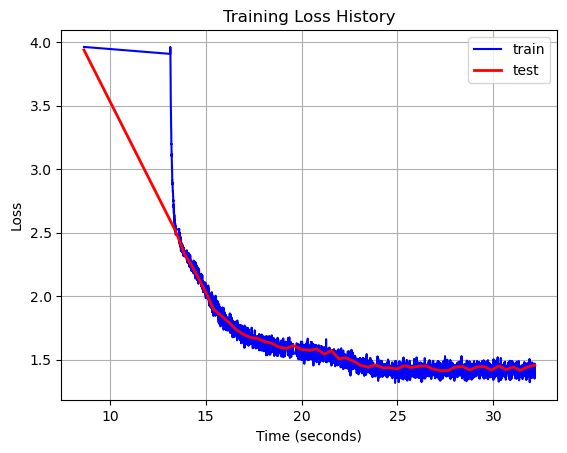

In [22]:
# plot the loss history
import matplotlib.pyplot as plt
plt.plot(time_history, loss_history, '-', label='train', color="blue")
plt.plot(time_test_history, loss_test_history, '-', label='test', lw=2, color="red")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training Loss History")
plt.grid()


✓ Figure saved to 'training_curves.png'


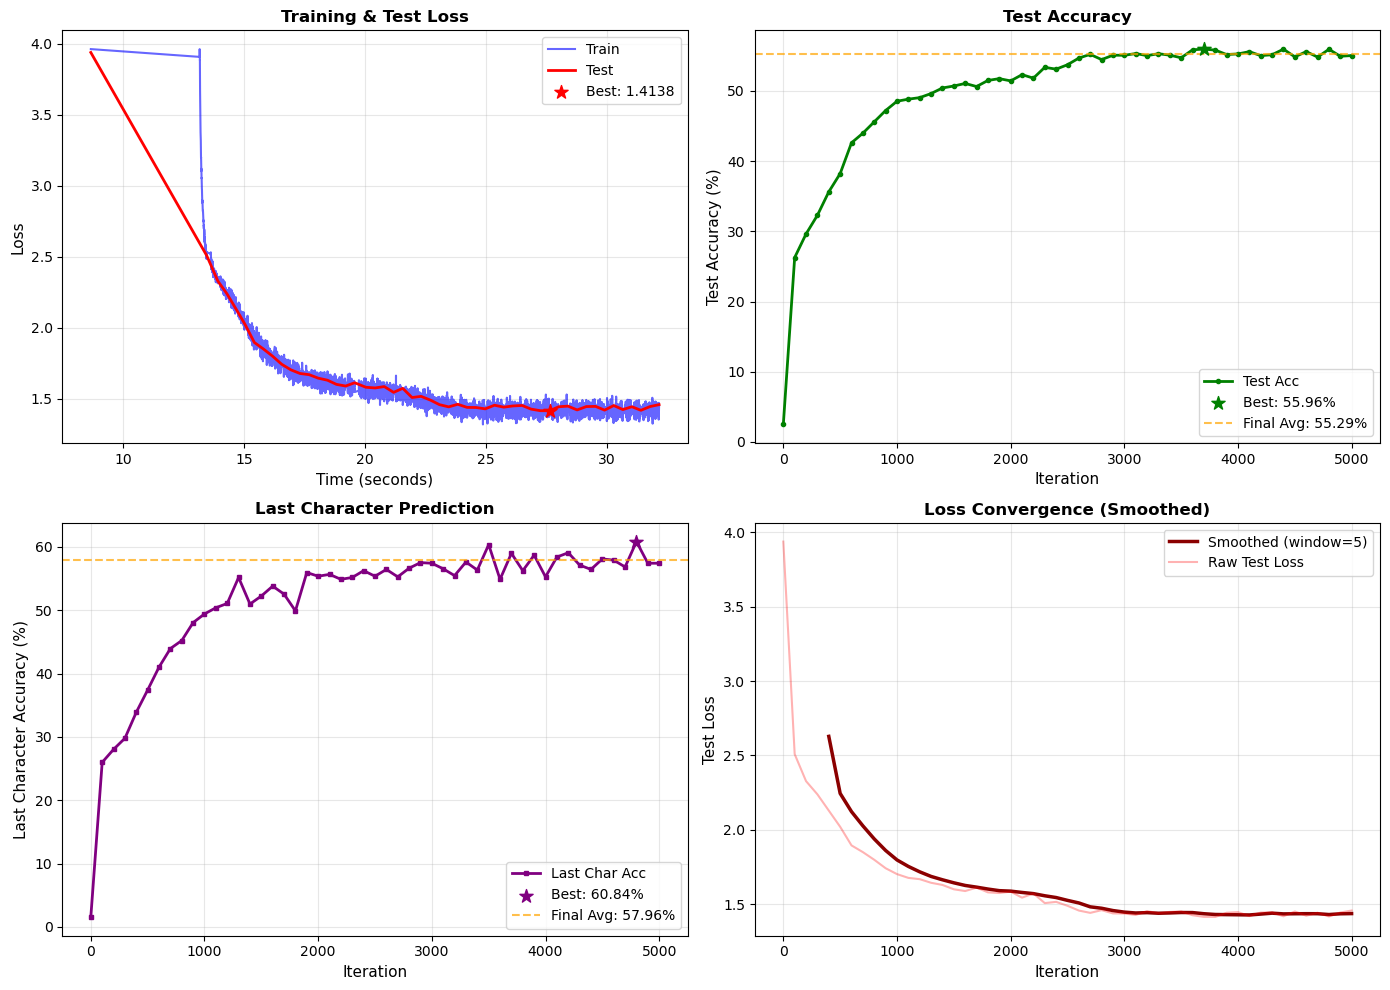

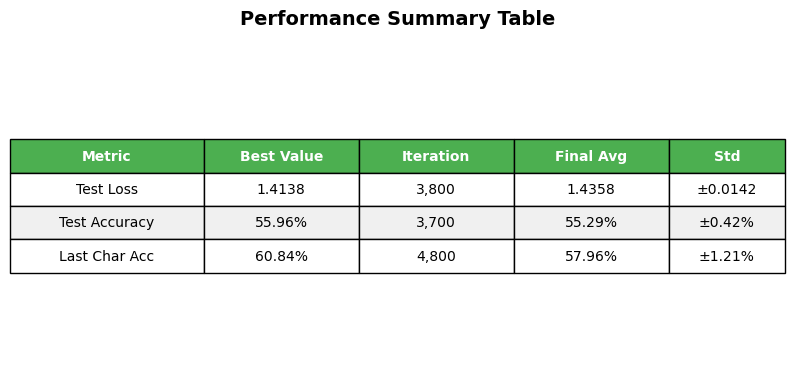

In [ ]:
import matplotlib.pyplot as plt

# Create a comprehensive figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ===== Plot 1: Loss Curves =====
ax1 = axes[0, 0]
ax1.plot(time_history, loss_history, '-', label='Train', color="blue", alpha=0.6)
ax1.plot(time_test_history, loss_test_history, '-', label='Test', lw=2, color="red")
# Mark best test loss
best_idx = np.argmin(loss_test_history)
ax1.scatter(time_test_history[best_idx], loss_test_history[best_idx],
           s=100, color='red', marker='*', zorder=5,
           label=f'Best: {loss_test_history[best_idx]:.4f}')
ax1.set_xlabel("Time (seconds)", fontsize=11)
ax1.set_ylabel("Loss", fontsize=11)
ax1.legend(loc='upper right')
ax1.set_title("Training & Test Loss", fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)

# ===== Plot 2: Accuracy Curves =====
ax2 = axes[0, 1]
ax2.plot(iteration_history, [100*x for x in acc_test_history], '-o',
        lw=2, markersize=3, color="green", label='Test Acc')
# Mark best accuracy
best_acc_idx = np.argmax(acc_test_history)
ax2.scatter(iteration_history[best_acc_idx], 100*acc_test_history[best_acc_idx],
           s=100, color='green', marker='*', zorder=5,
           label=f'Best: {100*acc_test_history[best_acc_idx]:.2f}%')
# Add final average line
n_final = min(10, len(acc_test_history))
final_avg = np.mean(acc_test_history[-n_final:]) * 100
ax2.axhline(y=final_avg, color='orange', linestyle='--', alpha=0.7,
           label=f'Final Avg: {final_avg:.2f}%')
ax2.set_xlabel("Iteration", fontsize=11)
ax2.set_ylabel("Test Accuracy (%)", fontsize=11)
ax2.legend(loc='lower right')
ax2.set_title("Test Accuracy", fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)

# ===== Plot 3: Last Character Accuracy =====
ax3 = axes[1, 0]
ax3.plot(iteration_history, [100*x for x in acc_last_test_history], '-s',
        lw=2, markersize=3, color="purple", label='Last Char Acc')
# Mark best
best_last_idx = np.argmax(acc_last_test_history)
ax3.scatter(iteration_history[best_last_idx], 100*acc_last_test_history[best_last_idx],
           s=100, color='purple', marker='*', zorder=5,
           label=f'Best: {100*acc_last_test_history[best_last_idx]:.2f}%')
# Add final average line
final_last_avg = np.mean(acc_last_test_history[-n_final:]) * 100
ax3.axhline(y=final_last_avg, color='orange', linestyle='--', alpha=0.7,
           label=f'Final Avg: {final_last_avg:.2f}%')
ax3.set_xlabel("Iteration", fontsize=11)
ax3.set_ylabel("Last Character Accuracy (%)", fontsize=11)
ax3.legend(loc='lower right')
ax3.set_title("Last Character Prediction", fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3)

# ===== Plot 4: Loss Convergence (smoothed) =====
ax4 = axes[1, 1]
# Smooth the test loss curve
window_size = max(1, len(loss_test_history) // 10)
if window_size > 1:
    smoothed_loss = np.convolve(loss_test_history,
                                np.ones(window_size)/window_size,
                                mode='valid')
    smoothed_iters = iteration_history[window_size-1:]
    ax4.plot(smoothed_iters, smoothed_loss, '-', lw=2.5, color='darkred',
            label=f'Smoothed (window={window_size})')
ax4.plot(iteration_history, loss_test_history, '-', alpha=0.3, color='red',
        label='Raw Test Loss')
ax4.set_xlabel("Iteration", fontsize=11)
ax4.set_ylabel("Test Loss", fontsize=11)
ax4.legend(loc='upper right')
ax4.set_title("Loss Convergence (Smoothed)", fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
print("\n Figure saved to 'training_curves.png'")
plt.show()

# ===== Additional: Summary Table Plot =====
fig2, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')

# Prepare summary data
summary_data = [
    ['Metric', 'Best Value', 'Iteration', 'Final Avg', 'Std'],
    ['Test Loss', f'{best_test_loss:.4f}', f'{best_test_loss_iter:,}',
     f'{final_loss.mean():.4f}', f'±{final_loss.std():.4f}'],
    ['Test Accuracy', f'{100*best_test_acc:.2f}%', f'{best_test_acc_iter:,}',
     f'{100*final_acc.mean():.2f}%', f'±{100*final_acc.std():.2f}%'],
    ['Last Char Acc', f'{100*best_test_acc_last:.2f}%', f'{best_test_acc_last_iter:,}',
     f'{100*final_acc_last.mean():.2f}%', f'±{100*final_acc_last.std():.2f}%'],
]

table = ax.table(cellText=summary_data, cellLoc='center', loc='center',
                colWidths=[0.25, 0.2, 0.2, 0.2, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style the header row
for i in range(5):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(summary_data)):
    for j in range(5):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

plt.title('Performance Summary Table', fontsize=14, fontweight='bold', pad=20)
plt.show()

In [20]:
B = 1
seed = 42
rng = jax.random.PRNGKey(seed)
prompt = "hello my fri"
# prompt_int = encode(prompt.lower())
prompt_int = jnp.array([[char_to_int.get(c, len(char_set)) for c in prompt.lower()[:64]]], dtype=jnp.int32)

gen_len = 1000
out_ids = generation.generate_tokens(model, params, rng, prompt_int, gen_len, block_size=64,
                          temperature=0.7, sample=True)
print('generated ids shape:', out_ids.shape)
print('generated text:')
generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
# concatenate with prompt
print(prompt + generated_text)
# print(''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0])))

2025-10-27 22:20:20.305637: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-10-27 22:20:20.305685: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-10-27 22:20:20.305777: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


generated ids shape: (1, 1000)
generated text:
hello my fri i ma c i o as a h sh ki da medo nii psane h f rame boloz secha t cha chra mu on unedoniri me ki g pa i fotra sa conidril ay kano atrine cdra nedj atane a an koani ane l serugrar wana tibilllleri so manine twa etolt in anero ne d ppe ideuma iseis wa scoceis mino ba di spo gane tcon mis ilocabrus i a chanec fola s enane the si ch si pay fopli a coproceisa f ei t rone wan chanese l ane chi r fl i he aloco am si at edea rof be wan he wanax i schy sira omi irearedirearen lis ge je one ha bonanhusa t ka m hanert shiariderusahi ma bo a ga g a povoroveanana co a a wal sauginomed f pe a fo coya o pprere l ryaisero to am aculaneau ft alan se i s raniscoma o l a a ra sin beitano ino le mili she c ge che f ffani ousisire t than m scorabla spora bopran taled hanilananina wasorera a enerochepani wa s a r s chen o mbo tranopan ddoura ano any fane m e shm iso att thega meromestho olane i s panolenora n chee micor s we i a wa steis jo wo boran